## MBTA Weekday Trip and Ridership Comparison


This program compares service and ridership across weekdays for the MBTA
transit network. 

It takes as an input a compliant GTFS feed and a table of ridership data
exported from the ODX origin-destination-transfer inference system.

The output is a table and set of charts that quantify and visualize the
match between service and ridership for each weekday for different time
periods.

Nick Caros, MIT Transit Lab, July 2021

In [1]:
import partridge as ptg
import pandas as pd
import datetime

### First, import data and compute trip, boarding totals

In [2]:
# Define user inputs
gtfs_inpath = 'data/mbta_gtfs_oct2019.zip'
ridership_inpath = 'data/mbta_records_oct2019_odx.p'

time_periods = {"Sunrise (3AM-6AM)" : [3, 6],
                "Early AM (6AM-7AM)" : [6, 7],
                "AM Peak (7AM-9AM)" : [7, 9],
                "Mid-day Base (9AM-1:30PM)" : [9, 13.5],
                "Mid-day School (1:30PM-4PM)" : [13.5, 16],
                "PM Peak (4PM-6:30PM)" : [16, 18.5],
                "Evening (6:30PM-10PM)" : [18.5, 22],
                "Late Evening (10PM-12AM)" : [22, 24],
                "Night (12AM-2AM)" : [24, 26],
                }

 # Monday of a typical week
typical_mon = datetime.date(2019, 10, 21)

Start with counting trips from GTFS

In [3]:
# Import GTFS feed for each day and filter out special routes
route_type = ['0', '1', '3']
route_desc = ['Rapid Transit','Key Bus', 'Commuter Bus', 'Local Bus']
feed_list = []
service_ids = ptg.read_service_ids_by_date(gtfs_inpath)
for weekday in range(5):
    day = typical_mon + datetime.timedelta(days=weekday)
    daily_service = service_ids[day]
    view = {'routes.txt': {'route_type': route_type, 'route_desc': route_desc}, 'trips.txt': {'service_id': daily_service}}
    feed = ptg.load_feed(gtfs_inpath, view)
    feed_list.append(feed)

print(feed_list)

[<partridge.gtfs.Feed object at 0x000001E18CF9ED30>, <partridge.gtfs.Feed object at 0x000001E18CF9E070>, <partridge.gtfs.Feed object at 0x000001E18CFB1A00>, <partridge.gtfs.Feed object at 0x000001E18CFFC130>, <partridge.gtfs.Feed object at 0x000001E18C706B80>]


In [4]:
# Arrange time periods into bins
bin_range = [0]
for period in time_periods:
    bin_range.append(int(time_periods[period][1] * 3600))

print(bin_range)

[0, 21600, 25200, 32400, 48600, 57600, 66600, 79200, 86400, 93600]


In [5]:
# Find avg. number of trips per period, per weekday, per route
trips_dict = {}
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for index, feed in enumerate(feed_list):
    
    # Import trips as df
    trips = feed.trips[['route_id', 'trip_id']]
    
    # Get trip start time and append to trip df
    trip_start = feed.stop_times[['trip_id', 'arrival_time', 'stop_sequence']]
    trip_start = trip_start.groupby(['trip_id'], as_index=False).agg({'stop_sequence': 'min', 'arrival_time': 'first'})
    trip_start = trip_start[['trip_id', 'arrival_time']]
    trips = pd.merge(trips, trip_start, on='trip_id')[['route_id', 'arrival_time']]

    # Group by route, time period
    trips = trips.groupby(['route_id', pd.cut(trips.arrival_time, bin_range, labels=time_periods.keys())]).count()
    trips_dict[day_list[index]] = trips.groupby(level=0).apply(lambda trips: trips.xs(trips.name)['arrival_time'].to_dict()).to_dict()

# Add full day total for each route
for day in trips_dict:
    for route in trips_dict[day]:
        total = 0
        for period in trips_dict[day][route]:
            total += trips_dict[day][route][period]
        trips_dict[day][route]['Full Day'] = total

trips_dict['Monday']['1']

{'Sunrise (3AM-6AM)': 12.0,
 'Early AM (6AM-7AM)': 15.0,
 'AM Peak (7AM-9AM)': 32.0,
 'Mid-day Base (9AM-1:30PM)': 54.0,
 'Mid-day School (1:30PM-4PM)': 32.0,
 'PM Peak (4PM-6:30PM)': 40.0,
 'Evening (6:30PM-10PM)': 45.0,
 'Late Evening (10PM-12AM)': 18.0,
 'Night (12AM-2AM)': 10.0,
 'Full Day': 258.0}

Next, count boardings from ODX

In [6]:
# Import ridership data and remove records with no boards
ridership_df = pd.read_pickle(ridership_inpath)[['route', 'stop_time', 'passenger_on']]
ridership_df = ridership_df[ridership_df['passenger_on'] > 0]

# Split arrival time into day of week and seconds
ridership_df['stop_time'] = pd.to_datetime(ridership_df['stop_time'])
ridership_df['weekday'] = ridership_df['stop_time'].dt.dayofweek
ridership_df['arrival_time'] = ridership_df['stop_time'].dt.hour * 3600 + ridership_df['stop_time'].dt.minute * 60 + ridership_df['stop_time'].dt.second
ridership_df = ridership_df[['weekday', 'route', 'arrival_time']]

ridership_df.head()

,weekday,route,arrival_time
0,2,62,22911
1,1,62,22976
3,3,62,22427
4,1,62,22976
5,4,62,22507


In [7]:
# Make modifications when arrival is after midnight but before next day of service
mod_weekday = []
mod_arrivaltime = []
for record in ridership_df.values.tolist():
    weekday = record[0]
    arrival_time = record[2]
    if arrival_time < 9000:
        mod_weekday.append(day_list[weekday-1])
        mod_arrivaltime.append(arrival_time + 86400)
    else:
        mod_weekday.append(day_list[weekday])
        mod_arrivaltime.append(arrival_time)

ridership_df['weekday'] = mod_weekday
ridership_df['arrival_time'] = mod_arrivaltime

# Convert route id to string for consistency with trip dict
ridership_df['route'] = ridership_df['route'].apply(str)

ridership_df.head()

,weekday,route,arrival_time
0,Wednesday,62,22911
1,Tuesday,62,22976
3,Thursday,62,22427
4,Tuesday,62,22976
5,Friday,62,22507


In [8]:
# Find avg. number of boardings per period, per weekday, per route
ridership_df = ridership_df.groupby(['weekday', 'route', pd.cut(ridership_df.arrival_time, bin_range, labels=time_periods.keys())]).count()
ridership_df.columns = ['count']
ridership_df = ridership_df.reset_index()
ridership_dict = {}
for day in day_list:
    day_df = ridership_df[ridership_df['weekday'] == day][['route', 'arrival_time', 'count']]
    day_df = day_df.groupby(['route', 'arrival_time']).sum()
    ridership_dict[day] = day_df.groupby(level=0).apply(lambda day_df: day_df.xs(day_df.name)['count'].to_dict()).to_dict()

# Add full day total for each route
for day in ridership_dict:
    for route in ridership_dict[day]:
        total = 0
        for period in ridership_dict[day][route]:
            total += ridership_dict[day][route][period]
        ridership_dict[day][route]['Full Day'] = total 
        
ridership_dict['Monday']['1']

{'Sunrise (3AM-6AM)': 110.0,
 'Early AM (6AM-7AM)': 243.0,
 'AM Peak (7AM-9AM)': 693.0,
 'Mid-day Base (9AM-1:30PM)': 1338.0,
 'Mid-day School (1:30PM-4PM)': 775.0,
 'PM Peak (4PM-6:30PM)': 1026.0,
 'Evening (6:30PM-10PM)': 995.0,
 'Late Evening (10PM-12AM)': 295.0,
 'Night (12AM-2AM)': 84.0,
 'Full Day': 5559.0}

Finally, combine data into a single dictionary

In [9]:
full_dict = {}
for day in trips_dict:
    full_dict[day] = {}
    for route in trips_dict[day]:
        full_dict[day][route] = {}
        for period in trips_dict[day][route]:
            full_dict[day][route][period]={}
            full_dict[day][route][period]['Trips'] = trips_dict[day][route][period]
            try:
                full_dict[day][route][period]['Boardings'] = ridership_dict[day][route][period]
            except KeyError:
                full_dict[day][route][period]['Boardings'] = 0
  
full_dict['Monday']['1']

{'Sunrise (3AM-6AM)': {'Trips': 12.0, 'Boardings': 110.0},
 'Early AM (6AM-7AM)': {'Trips': 15.0, 'Boardings': 243.0},
 'AM Peak (7AM-9AM)': {'Trips': 32.0, 'Boardings': 693.0},
 'Mid-day Base (9AM-1:30PM)': {'Trips': 54.0, 'Boardings': 1338.0},
 'Mid-day School (1:30PM-4PM)': {'Trips': 32.0, 'Boardings': 775.0},
 'PM Peak (4PM-6:30PM)': {'Trips': 40.0, 'Boardings': 1026.0},
 'Evening (6:30PM-10PM)': {'Trips': 45.0, 'Boardings': 995.0},
 'Late Evening (10PM-12AM)': {'Trips': 18.0, 'Boardings': 295.0},
 'Night (12AM-2AM)': {'Trips': 10.0, 'Boardings': 84.0},
 'Full Day': {'Trips': 258.0, 'Boardings': 5559.0}}

### Now, visualize selected results

In [10]:
import matplotlib.pyplot as plt
import numpy as np

Choose a route and time period

In [12]:
selected_route = '1'
selected_period = list(time_periods.keys())[2] # could also use input list to specify, i.e. list(time_periods.keys())[2]

Lookup trip and ridership data

In [13]:
trip_list = []
boardings_list = []
for day in full_dict:
    data = full_dict[day][selected_route][selected_period]
    trip_list.append(data['Trips'])
    boardings_list.append(data['Boardings'])

Plot results

<ipython-input-14-2b974152ed49>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


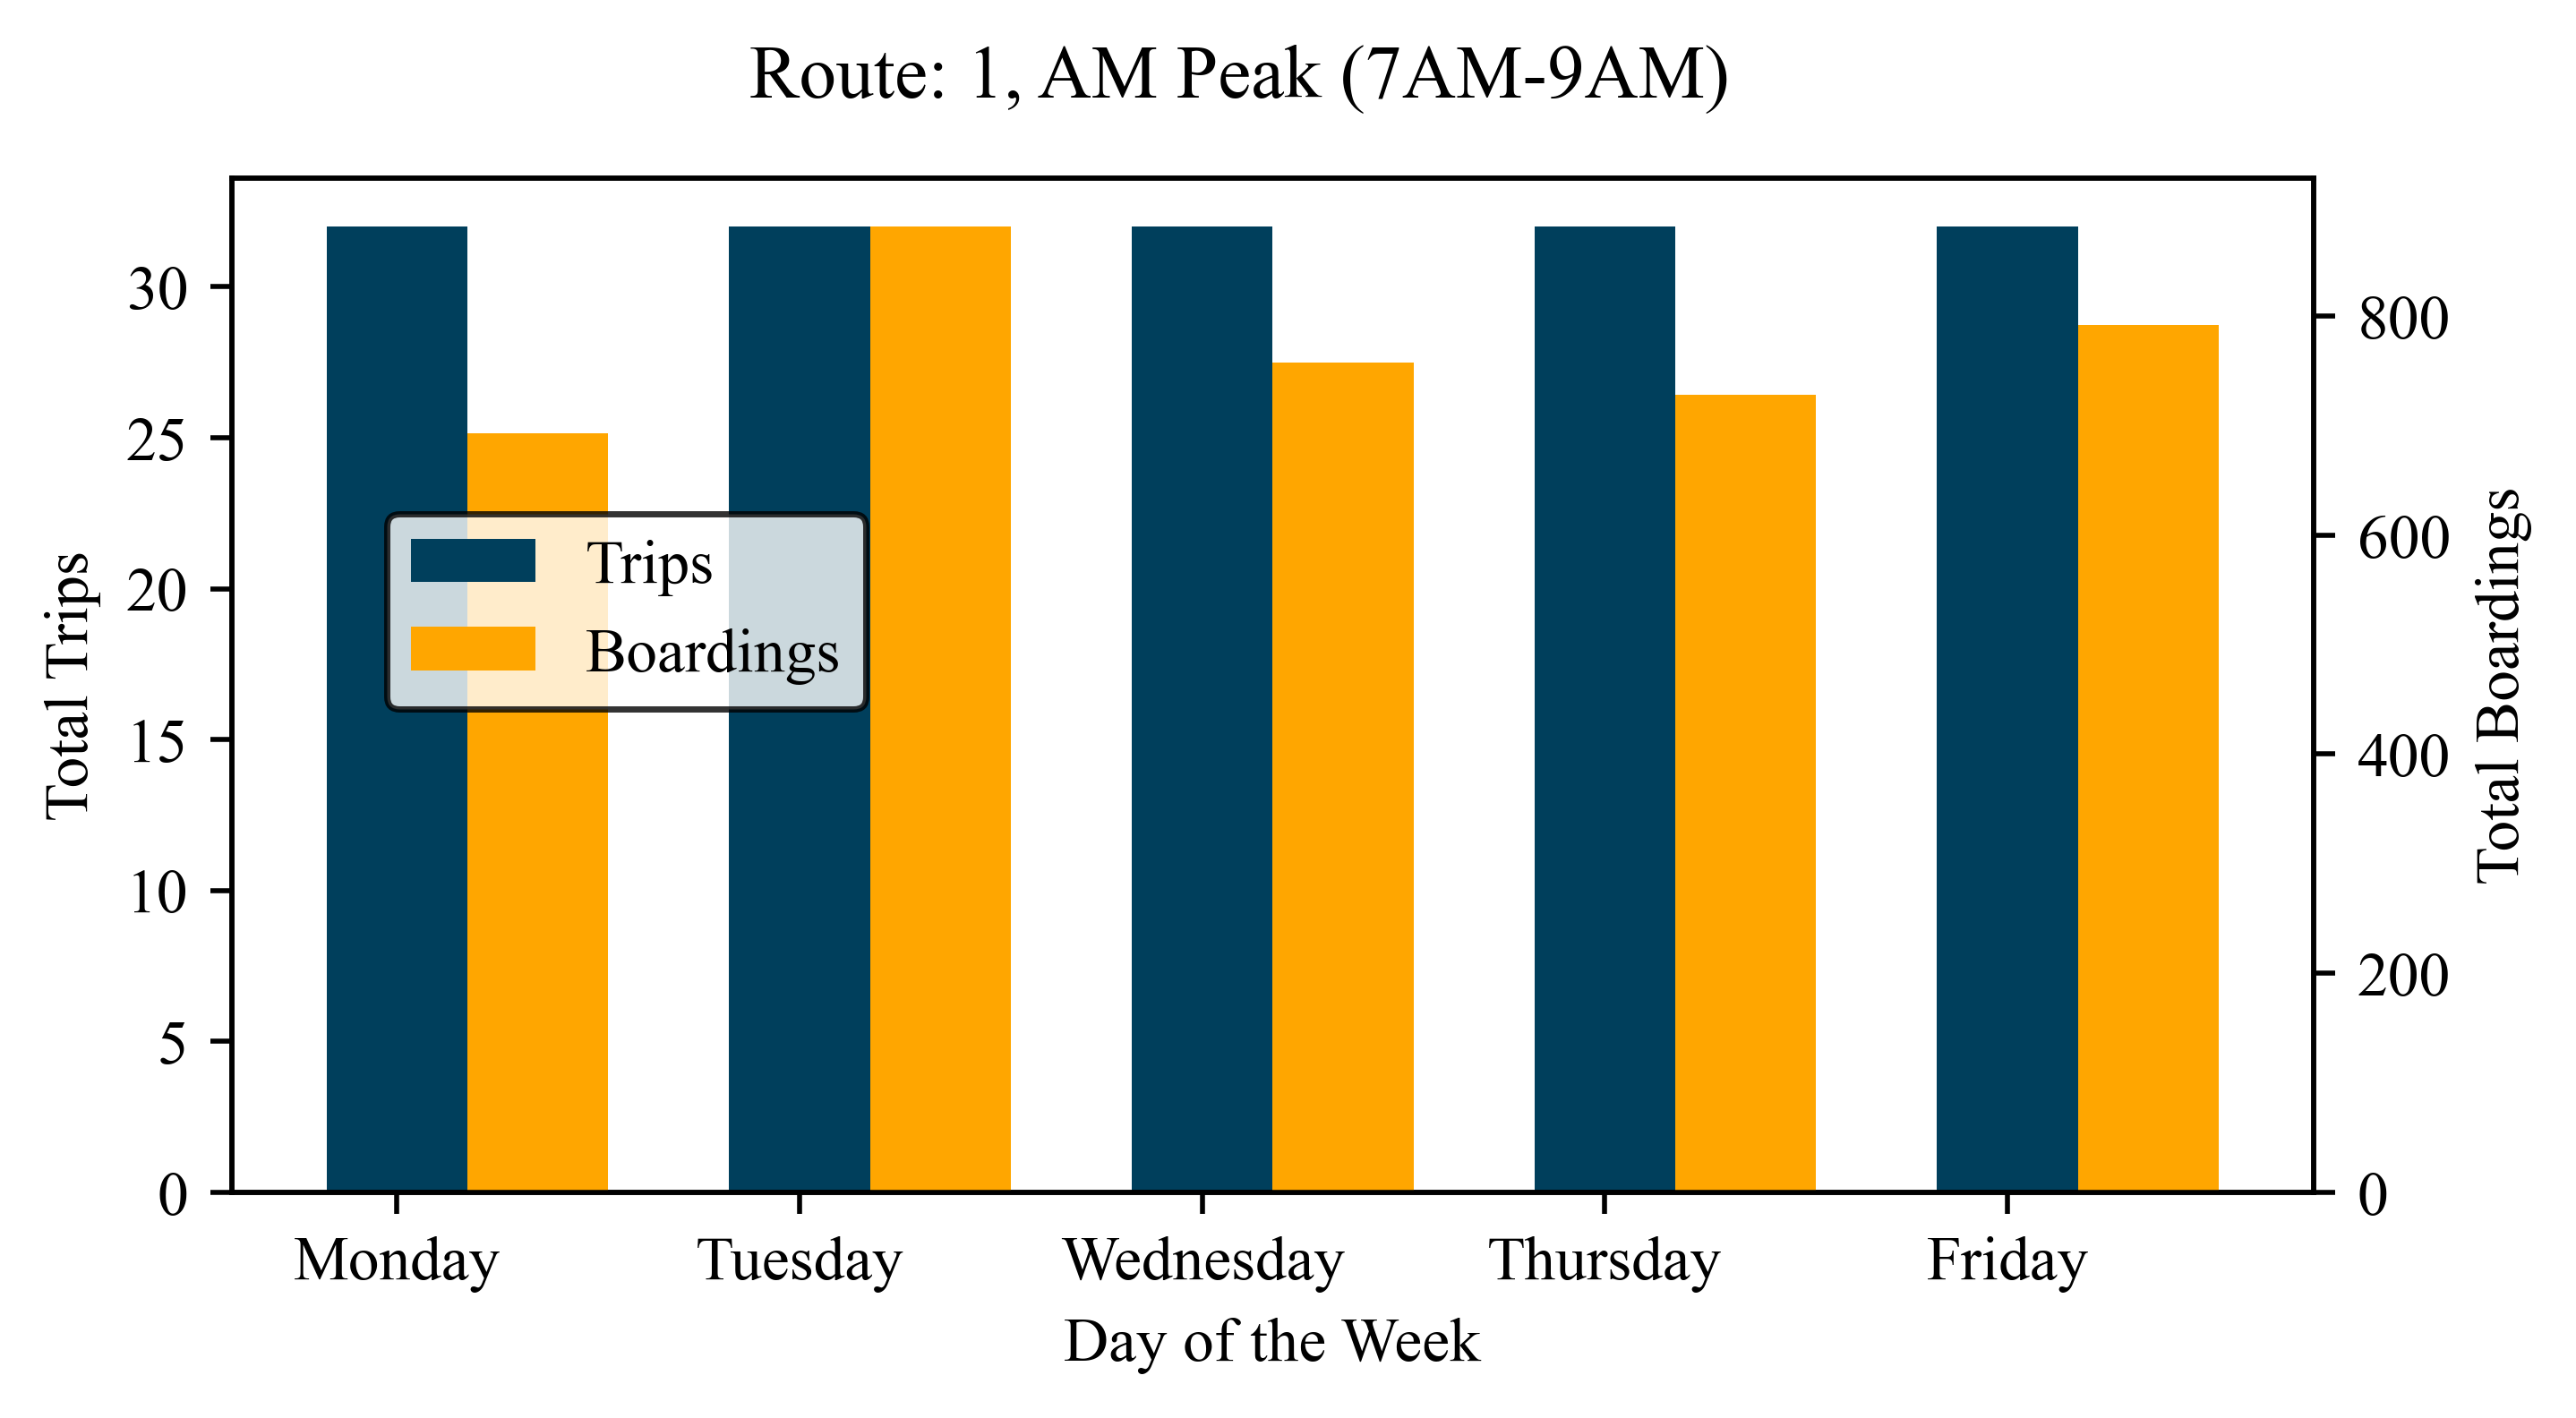

In [14]:
plt.rcParams.update({'font.size': 10})
plt.rcParams["font.family"] = "Times New Roman"
fig, ax1 = plt.subplots(dpi=500,figsize=(6,3))
x = np.arange(5)
width = 0.35

ax1.set_xlabel(r'Day of the Week')
ax1.set_ylabel(r'Total Trips')
ax1.bar(x - width/2, height = trip_list, tick_label = day_list, label='Trips', color='#003f5c', width = width)
ax1.set_ylim(0) # Force start at 0

ax2 = ax1.twinx()
ax2.set_ylabel('Total Boardings')
ax2.bar(x + width/2, height = boardings_list, color='#ffa600', label='Boardings', width = width)
fig.legend(loc=(0.15, 0.5)).get_frame().set_edgecolor('black')
ax2.set_ylim(0) # Force start at 0
fig.suptitle('Route: ' + selected_route + ", " + selected_period)

fig.show()